In [1]:
# Get important libraries for this class.
import input_data
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output

In [2]:
import os
from urllib.request import urlopen
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA

In [23]:
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt

In [4]:
class SimilarityBase:
    def get_k_nn_column(self, k):
        def f(vector):
            v = np.zeros(len(vector))
            indices = np.argsort(vector)
            v[indices[0:k]] = vector[indices][0:k]
            return v
        return f
    def get_k_nn_column_rev(self, k):
        def f(vector):
            v = np.zeros(len(vector))
            rev_indices = np.argsort(vector)[::-1]
            v[rev_indices[0:k]] = vector[rev_indices][0:k]
            return v
        return f
    def sigmoidal_normalize(self, v):
        v = (v - min(v)) / (max(v) - min(v))
        return v

In [5]:
class Normalized_Cosine_Similarity(SimilarityBase):
    def __init__(self, Normalize: object) -> object:
        self.Normalize = Normalize

    def get_matrix(self, data):
        if self.Normalize:
            data = normalize(data, axis=0)
        m = squareform(pdist(data, 'cosine'))
        m = np.dot(LA.matrix_power(np.diag(np.sum(m, 0)), -1), m)
        if self.Normalize:
            m = np.apply_along_axis(self.sigmoidal_normalize, 1, m)
        np.fill_diagonal(m, 0.)
        return m

In [6]:
class Nearest_Neighbors_Similarity(SimilarityBase):
    def __init__(self, Normalize: object) -> object:
        self.Normalize = Normalize
    def get_matrix(self, data):
        if self.Normalize:
            data = normalize(data, axis=0)
        from sklearn.neighbors import kneighbors_graph
        n_neighbors = max(int(data.shape[0] / 10), 1)
        m = kneighbors_graph(data, n_neighbors, mode='connectivity', include_self=True)
        m = m.toarray()
        if self.Normalize:
            m = np.apply_along_axis(self.sigmoidal_normalize, 1, m)
        np.fill_diagonal(m, 0.)
        return m

In [7]:
class SimilarityBasedDatasetIterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, n):
        return (self.matrix.transpose(), self.labels)
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [8]:
class DatasetIterator:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def next_batch(self, n):
        return (self.data, self.labels)
    def whole_dataset(self):
        return (self.data, self.labels)

In [9]:
def download_wine_data(directory):
    if not os.path.isdir(directory):
        os.makedirs(directory)
    if not os.path.exists(directory + '/' + 'wine.data'):
        response = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data')
        data = response.read()
        f = open(directory + '/' + 'wine.data', 'wb')
        f.write(data)
        f.close()
    data = np.genfromtxt(directory + '/' + 'wine.data', delimiter=',')
    labels = data[:,0]
    data = data[:,1:]
    return (data, labels)
def read_wine_data(similarity):
    data, labels = download_wine_data(directory="Wine_Dataset/")
    return SimilarityBasedDatasetIterator(data, labels, similarity)

In [10]:
data_set = read_wine_data(Normalized_Cosine_Similarity(Normalize=True))

In [11]:
# The autoencoder architecture
n_encoder_hidden_1 = 178
n_encoder_hidden_2 = 128
n_encoder_hidden_3 = 64
# Here we have low dimensional embedding to reconstruct the input.
n_decoder_hidden_1 = 64
n_decoder_hidden_2 = 128
n_decoder_hidden_3 = 178

In [12]:
def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [178, n_encoder_hidden_1], [n_encoder_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_encoder_hidden_1, n_encoder_hidden_2], [n_encoder_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_encoder_hidden_2, n_encoder_hidden_3], [n_encoder_hidden_3], phase_train)
        with tf.variable_scope("code"):
            code = layer(hidden_3, [n_encoder_hidden_3, n_code], [n_code], phase_train)
    return code

In [13]:
def decoder(code, n_code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_decoder_hidden_1], [n_decoder_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_decoder_hidden_1, n_decoder_hidden_2], [n_decoder_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_decoder_hidden_2, n_decoder_hidden_3], [n_decoder_hidden_3], phase_train)
        with tf.variable_scope("output"):
            output = layer(hidden_3, [n_decoder_hidden_3, 178], [178], phase_train)
    return output

In [14]:
def layer_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)

    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)

    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)

    mean, var = control_flow_ops.cond(phase_train,
                                      mean_var_with_update,
                                      lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var,
                                                        beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [15]:
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(1.0 / weight_shape[0]) ** 0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape,
                        initializer=weight_init)
    b = tf.get_variable("b", bias_shape,
                        initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.sigmoid(layer_batch_norm(logits, weight_shape[1], phase_train))

In [16]:
def loss(output, x):
    with tf.variable_scope("training"):
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_loss = tf.reduce_mean(l2)
        train_summary_op = tf.summary.scalar("train_cost", train_loss)
        return train_loss, train_summary_op

In [17]:
def training(cost, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08,
                                       use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [18]:
def evaluate(output, x):
    with tf.variable_scope("validation"):
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        val_loss = tf.reduce_mean(l2)
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        return val_loss, val_summary_op

In [19]:
# Parameters
n_code = '64' # The number of neurons in my code layers.
learning_rate = 0.01 #
training_epochs = 2000 # The time priod of train on the model.
batch_size = 100
display_step = 100

In [35]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_model"):                
        start_autoencoder_0ptimiz = time.time()        
        x = tf.placeholder("float", [None, 178])   
        phase_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), phase_train)
        output = decoder(code, int(n_code), phase_train)
        cost, train_summary_op = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = training(cost, global_step)
        eval_op, val_summary_op = evaluate(output, x)
        summary_op = tf.summary.merge_all()
        saver = tf.train.Saver(max_to_keep=200)
        sess = tf.Session()
        train_writer = tf.summary.FileWriter("ae_hidden=" + n_code + "_logs/", graph=sess.graph)
        val_writer = tf.summary.FileWriter("ae_hidden=" + n_code + "_logs/", graph=sess.graph)        
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        # Training cycle

In [36]:
results = []
steps = []
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(data_set.next_batch(1)[0].shape[0] / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        # Fit training using batch data
        _, new_cost, train_summary = sess.run([train_op, cost, train_summary_op],
                                              feed_dict={x: data_set.next_batch(1)[0], phase_train: True})
        train_writer.add_summary(train_summary, sess.run(global_step))
        # Compute average loss
        avg_cost += new_cost / total_batch
        # Display logs per epoch step
    if epoch % display_step == 0:
        train_writer.add_summary(train_summary, sess.run(global_step))
        #saver.save(sess, "ae_hidden=" + n_code + "_logs/model-checkpoint-" + '%04d' % (epoch + 1),
                   #global_step=global_step)        
    # GENERATING AE CODES AND RECONSTRUCTION
        ae_codes = sess.run(code, feed_dict={x: data_set.next_batch(178)[0], phase_train: True})
        
        centroids, _ = kmeans(ae_codes,3)
        idx, _ = vq(ae_codes, centroids)
        sae_nmi = normalized_mutual_info_score(data_set.next_batch(1)[1], idx)
        results.append(sae_nmi)
        steps.append(epoch)
        print(("NMI Score for SAE is: {:0.2f} ".format(sae_nmi)))

NMI Score for SAE is: 0.74 
NMI Score for SAE is: 0.80 
NMI Score for SAE is: 0.82 
NMI Score for SAE is: 0.82 
NMI Score for SAE is: 0.80 
NMI Score for SAE is: 0.79 
NMI Score for SAE is: 0.82 
NMI Score for SAE is: 0.82 
NMI Score for SAE is: 0.82 
NMI Score for SAE is: 0.83 
NMI Score for SAE is: 0.85 
NMI Score for SAE is: 0.84 
NMI Score for SAE is: 0.84 
NMI Score for SAE is: 0.84 
NMI Score for SAE is: 0.84 
NMI Score for SAE is: 0.84 
NMI Score for SAE is: 0.84 
NMI Score for SAE is: 0.84 
NMI Score for SAE is: 0.84 
NMI Score for SAE is: 0.84 


In [39]:
plt.figure(figsize=(14, 6))
plt.errorbar(steps, results, label='ASE on Normalized Cosine Similarity', color='r')
plt.xlabel('Result of KMeans on Embedding Data in per Step.')
plt.ylabel('NMI')
plt.grid()
plt.title(('Result of ASE after {:d} steps.').format(len(steps)))
plt.legend(loc='best')

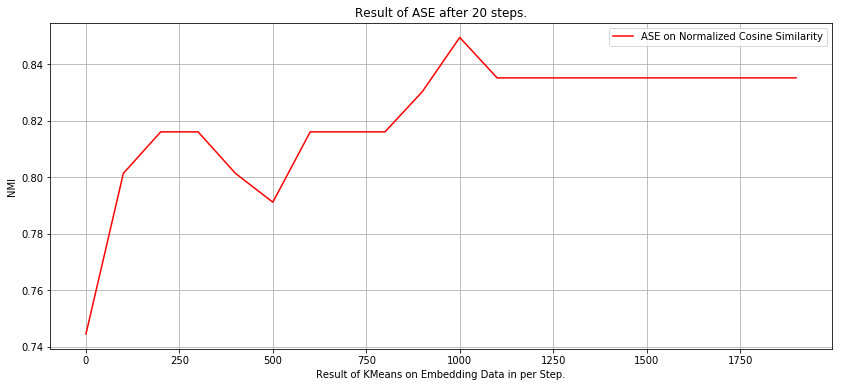

In [40]:
plt.show()